# Seminar 1. Likelihood-based models.

This seminar will be about likelihood-based models: autoregressive and flow-based. Agenda:
- Likelihood model in 1D - fitting histogram using SGD
- Deep Autoregressive model in 2D
- Detaled study of Real NVP model in 2D 



# Part 1. Fitting histogram.

In this part we will build our first likelihood-based model for 1D data and will try to fit it using gradient methods.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torch.utils.data
import math
from sklearn.model_selection import train_test_split
import random

Choose your device: don't forget to switch to GPU runtime when working in collab with cuda.

In [2]:
device = 'cuda'

In [3]:
torch.manual_seed(42)

First, we define the procedure of data generation. It will generate a dataset of samples $x \in \{0 \dots 99\}$

In [4]:
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

We generate data and perform train/val/test split.

In [5]:
data = sample_data()
train_data, test_data = train_test_split(data, test_size = 0.3)
train_data, val_data = train_test_split(train_data, test_size = 0.3)

Let's plot and visualize the histogram of training data!

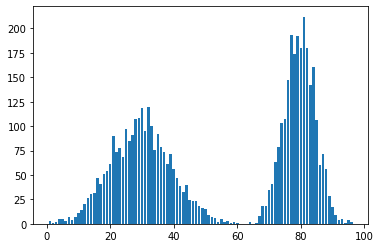

In [6]:
def plot_histogram(data):
    counts = Counter(data)
    keys = list(counts.keys())
    values = list(counts.values())
    plt.bar(keys, values)
    plt.show()

plot_histogram(train_data)

On lecture we have discussed how to build histogram model. But this model is not the best choice for high-dimensional data. So, we suggesst to you to implement the following parametrized model:

$$ p_\theta(x)_i = \frac{e^{\theta_i}}{\sum_j{e^{\theta_j}}} $$

Where $\theta=(\theta_0 \dots \theta_{99})$

We propose you to implement this model in the following class

In [7]:
class SimpleProbabilityModel(nn.Module):
    # Store all parameters of your model as class fields in constructor
    def __init__(self,  num_elements=100):
        super(SimpleProbabilityModel, self).__init__()
        self.teta = torch.nn.Parameter(torch.randn((num_elements)))
        self.softmax = nn.LogSoftmax()
        
    # Forward should return vector of log probabilities for each element
    def forward(self):
        return self.softmax(self.teta)
    
    # Should sample element using probabilities, obtained from parameters. Return single number 0..99
    def sample(self):
        return torch.multinomial(F.softmax(self.teta), 1)
        
        

We will train this model using negative log-likelihood optimization: $ L_i = -\log p_{y_i} $. Implement this loss calculation for your model given a batch of data samples.

In [8]:
counts, _ = np.histogram(data, bins=range(101))
counts.sum()


10000

In [9]:
loss = torch.nn.KLDivLoss(reduction='batchmean')

In [10]:
# data: n.array of numbers from your training distribution
# model: instance of your SimpleProbabilityModel.
# should return: negative log-likelihood of your data given the model to perform backpropagation
def calc_loss(data, model):
    return -model()[data].mean()

Finally, we can create instance of our model and perform training. Note that if your calculated previous loss as classic natural logarithm, here we scale it to binary logarithm for logging likelihood in bits (which is better for interpretation and comparisons).

In [11]:
model = SimpleProbabilityModel().to(device)

In [12]:
from tqdm import tqdm

def train_simple_model(model, train_data, val_data, num_epochs=20000, batch_size=4000, lr=0.01):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    for i in tqdm(range(num_epochs)):
        for j in range(len(train_data) // batch_size):
            optimizer.zero_grad()
            batch = train_data[batch_size * j:batch_size * (j + 1)]
            l = calc_loss(batch, model)
            train_losses.append(l.item() / math.log(2))
            l.backward()
            optimizer.step()
        l = calc_loss(val_data, model)
        val_losses.append(l.item() / math.log(2))
    
    print("Train NLL(bits)")
    plt.plot(train_losses, color='green')
    plt.show()

    print("Val NLL(bits)")
    plt.plot(val_losses, color='red')
    plt.show()
    
    print("Final validation NLL(bits): {}".format(val_losses[-1]))

  0%|          | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_8067/2568120010.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(self.teta)
100%|██████████| 50000/50000 [10:47<00:00, 77.24it/s]


Train NLL(bits)


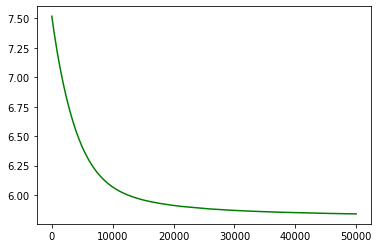

Val NLL(bits)


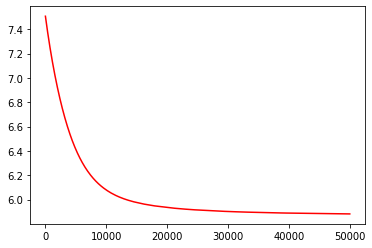

Final validation NLL(bits): 5.881525983821847


In [13]:
train_simple_model(model, train_data, val_data, num_epochs=50000)

You can also tune your training parameters (number of epochs, batch size, learning rate, optimizer), to improve validation NLL. You should obtain something below 6.

Finally, let's sample values from our model and visualize histograms of our test data and our sample data.

In [14]:
sampled_data = [model.sample().cpu().item() for _ in range(len(test_data))]

/tmp/ipykernel_8067/2568120010.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.multinomial(F.softmax(self.teta), 1)


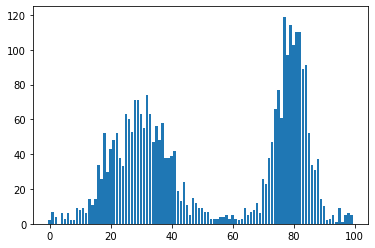

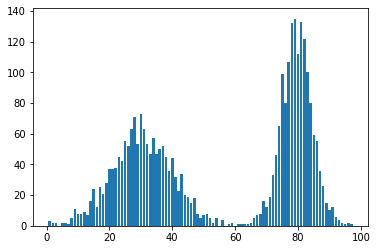

In [15]:
plot_histogram(sampled_data)
plot_histogram(test_data)

Training here might not yield perfect results, but pictures should look at least similar.

In [16]:
torch.save(model.state_dict(), './model.pth')

# Part 2. 2D discrete data. Autoregressive model

In this part we will built our own autoregressive model to work with two-dimensional discrete data data. 

We will load 2D distribution as is from file. It's 200x200 numpy array with probabilities.

In [17]:
# For colab users: download file
! wget https://github.com/egiby/Generative-Models-MIPT/raw/main/module1-likelihood/distribution.npy

--2023-03-21 23:14:46--  https://github.com/egiby/Generative-Models-MIPT/raw/main/module1-likelihood/distribution.npy
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/egiby/Generative-Models-MIPT/main/module1-likelihood/distribution.npy [following]
--2023-03-21 23:14:46--  https://raw.githubusercontent.com/egiby/Generative-Models-MIPT/main/module1-likelihood/distribution.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160128 (156K) [application/octet-stream]
Saving to: ‘distribution.npy.1’

distribution.npy.1  100%[===================>] 156,38K  --.-KB/s    in 0,06s   

2023-03-21 23:14:47 (2

In [18]:
original_distribution = np.load("distribution.npy")

Let's define class to sample pair of numbers $(x,y) \in \{0 \dots 199\}^2$ from this distribution.

In [19]:
class SampleDist:
    def __init__(self, distribution):
        self.probabilities = distribution.flatten()
        self.rows, self.cols = distribution.shape
        self.values = np.array([[i // self.cols, i % self.cols] for i in range(self.rows * self.cols)])

    def sample(self):
        idx = np.random.choice(self.rows * self.cols, p = self.probabilities)
        
        return self.values[idx]

So, we define distribution, sample data and create train/val/test splits.

In [20]:
dist2D = SampleDist(original_distribution)

In [21]:
SIZE = 100000
sampled_data = np.array([dist2D.sample() for _ in range(SIZE)])

In [22]:
train_data, test_data = train_test_split(sampled_data, test_size = 0.2)
train_data, val_data = train_test_split(train_data, test_size = 0.2)

We will build our autoregressive model in $(x, y)$ as follows:

- Train marginal model $p(x)$ as in part 1
- Create and train conditional model $p(y|x)$ as multi-layer neural network

Here, create class for your conditional model $p(y|x)$. It should take $x$ as batch of integer inputs and return batch of probability distributions over $y$.

In [23]:
class ConditionalModel(nn.Module):
    # Store all your trainable layers as model fiels in constuctor
    def __init__(self, x_range=200, embedding_dim=200, hidden_dim=200, output_dim=200):
        super(ConditionalModel, self).__init__()
        
        self.net = nn.Sequential(
            nn.Embedding(x_range, embedding_dim),
            nn.Linear(embedding_dim, hidden_dim),
            nn.Linear(hidden_dim, output_dim),
            nn.LogSoftmax(dim=-1)
        )
    
    # Forward pass takes LongTensor x of shape (N,) and should return predicted logprobs of shape (N, 200)
    def forward(self, x):
        return self.net(x)

Finally, create a model and train it.

In [24]:
cond_model = ConditionalModel().to(device)

In [25]:
from tqdm import tqdm

def train_cond_model(cond_model, train_data, num_epochs=200, lr=0.001, batch_size=10000):
    dataset = torch.utils.data.TensorDataset(torch.LongTensor(train_data.T[0]).to(device), 
                                             torch.LongTensor(train_data.T[1]).to(device))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss = nn.NLLLoss()
    optimizer = optim.Adam(cond_model.parameters(), lr=lr)
    
    train_losses = []
    
    for i in tqdm(range(num_epochs)):
        for X_train, Y_train in dataloader:
            optimizer.zero_grad()
            predictions = cond_model(X_train)
            l = loss(predictions, Y_train)
            l.backward()
            optimizer.step()
            
            train_losses.append(l.item() / math.log(2))
    
    print("Train NLL(bits)")
    plt.plot(train_losses, color='green')
    plt.show()
    return train_losses

100%|██████████| 200/200 [03:47<00:00,  1.14s/it]


Train NLL(bits)


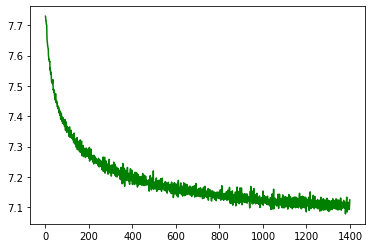

In [26]:
losses = train_cond_model(cond_model, train_data)

To build compound model, we will also need our simple model from part 1, trained on marginal data from our distribution (only x values).

  0%|          | 0/5000 [00:00<?, ?it/s]/tmp/ipykernel_8067/2568120010.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(self.teta)
100%|██████████| 5000/5000 [11:57<00:00,  6.97it/s]


Train NLL(bits)


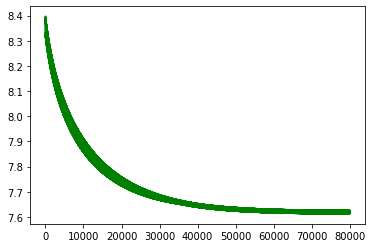

Val NLL(bits)


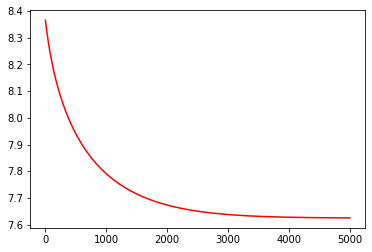

Final validation NLL(bits): 7.625360582579779


In [27]:
x_model = SimpleProbabilityModel(num_elements=200).to(device)
train_simple_model(x_model, train_data.T[0], val_data.T[0], num_epochs=5000)

Finally, we are ready to build compound model for our total $(x, y)$ distribution modeling. Having two trained models implement sampling procedure and probability calculation.

In [28]:
class CompoundModel:
    def __init__(self, x_model, cond_model):
        self.x_model = x_model
        self.cond_model = cond_model
        
        self.x_model.eval()
        self.cond_model.eval()
    
    # Given two numbers x, y from 0 .. 199, return NLL value -log p(x,y)
    # Normalize in in the way it will return NLL in bits / dimention (binary log divided by two in our case)
    def get_logprob(self, x, y):
        #return -self.x_model()[x] - self.cond_model(torch.tensor([x]).to(device))[0, y]
        return -self.x_model()[x.cpu().numpy()] - self.cond_model(x)[y.cpu().numpy()]
    
    # Implement sampling procedure. One call should return sample (x, y) as numpy array from two elements
    def sample(self):
        x = self.x_model.sample()
        y = torch.multinomial(torch.exp(self.cond_model(x)), 1)
        return np.array([x.item(), y.item()])

In [29]:
compound_model = CompoundModel(x_model, cond_model)

Calculate total average NLL in bits / dimension on your validation data. Tune training parameters and conditional model architecture to boost your performance.

In [30]:
total_logprob = 0
for elem in val_data:
    logprob = compound_model.get_logprob(torch.tensor(elem[0]).to(device), torch.tensor(elem[1]).to(device))
    total_logprob += logprob
print("Total NLL on validation data per dimension: {}".format(total_logprob / val_data.shape[0]))

/tmp/ipykernel_8067/2568120010.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(self.teta)


Total NLL on validation data per dimension: 10.986934661865234


Check if sampling from your model works.

In [31]:
compound_model.sample()

/tmp/ipykernel_8067/2568120010.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.multinomial(F.softmax(self.teta), 1)


array([130, 107])

Finally, get enough samples from your final model and display 2D histogram of the results. Compare them with the results you can get from your test data.

In [32]:
sampled_2d_data = np.array([compound_model.sample() for _ in range(500000)])

/tmp/ipykernel_8067/2568120010.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.multinomial(F.softmax(self.teta), 1)


In [33]:
def plot_2dhistogram(data):
    plt.hist2d(data.T[0], data.T[1], bins=200, cmap='gray')
    plt.show()

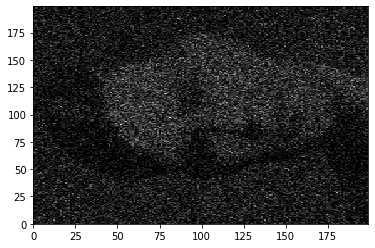

In [34]:
plot_2dhistogram(sampled_2d_data)

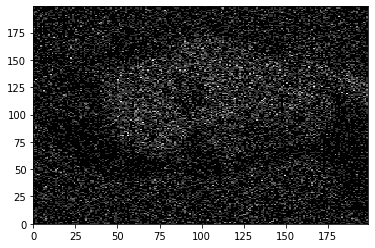

In [35]:
plot_2dhistogram(test_data)

Doesn't this picture resemble anything? (look at the rotated version of the histogram). Check out how your original distribution looks like!

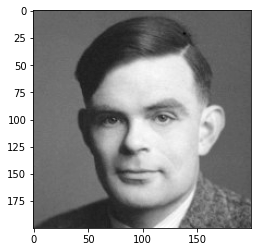

In [36]:
plt.imshow(original_distribution, cmap="gray")
plt.show()

# Part 3. 2D Continuous Data. RealNVP flow model

In this part we will build flow model, transforming given 2D continuous distribution to uniform 2D distribution. Our distribution will be represented as a set of samples. We will use RealNVP model, which we discussed on lecture.

First of all, we define function for data sampling, use it and perform train/val/test split as usual. This time all elements also have labels, associated with them. We wil use them for visualization purposes.

In [37]:
def sample_data():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

In [38]:
X, Y = sample_data()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2)

Let's take a look on a 2D histogram of our train set distribution.

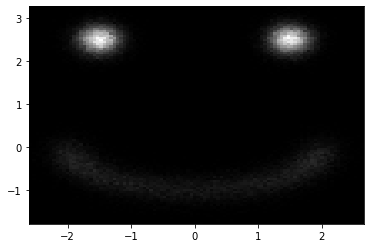

In [39]:
plt.hist2d(X_train.T[0], X_train.T[1], bins=100, cmap='gray')
plt.show()

Let's also visualize distribution in point form with different colors, associated with labels.

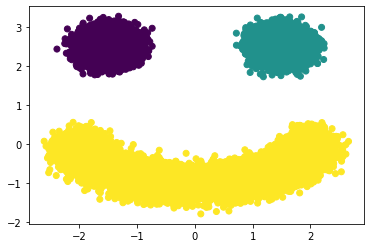

In [40]:
plt.scatter(X_train.T[0], X_train.T[1], c = Y_train)
plt.show()

We will build RealNVP flow model using affine coupling layer as main building block. In two-coordinates case it takes the following form:

$$ (x_1, x_2) \rightarrow (z_1, z_2) $$
$$ z_1 = x_1 $$
$$ z_2 = x_2 \cdot \sigma(s(x_1)) + t(x_1) $$

Where vector from $s, t$ values is calculated as neural network with $x_1$ on input and $\sigma$ is sigmoid function. Cool thing about RealNVP is that this network can be arbitrary complex and doesn't need to be invertible itself to have invertible flow for affine coupling layer!

Flows support composition and we will use it. In general, we will compose our total flow in the following way:

$$ (z_1, z_2) = (\sigma \circ f_{\theta, 1} \circ \dots \circ f_{\theta, n})(x_1, x_2) $$

Where $f_{\theta, i}$ is affine coupling layers described above. And $\sigma$ is elementwise sigmoid function

Important thing in flows training is loss function. In case of flows composition, log-likelihood objective takes the following form:

$$ \log p_\theta(x) = \log p_\theta(z) + \sum_i \log | \det \frac{\partial f_i}{\partial f_{i-1}}| $$

Here $\det \frac{\partial f_i}{\partial f_{i-1}}$ is Jacobian matrix determinant for each flow operation. And $\log p_\theta(z)$ is log likelihood of latent space we are mapping to (in our case $U(0, 1)^2$)

Answer the following questions (you will need the answers to complete your RealNVP model code):

1. What is $\log | \det \frac{\partial f_i}{\partial f_{i-1}} |$ for affine coupling operation?
2. What is $\log | \det \frac{\partial f_i}{\partial f_{i-1}} |$ for elementwise sigmoid operation?
3. What are the inverse operations for both sigmoid and affine coupling?
4. How $\log p_\theta(z)$ in case of $U(0, 1)^2$ can be calculated?

We will start implementation of RealNVP from affine coupling layer. You will need to implement inverse operation calculations as well as objective update for each layer ($\log | \det \frac{\partial f_i}{\partial f_{i-1}} |$).

In [41]:
class AffineCoupling(nn.Module):
    def __init__(self, num_features=2, hidden_dim=100):
        super(AffineCoupling, self).__init__()
        # Store your NN model for s and t values calculation
        # Your network should take num_features // 2 elements on input (1 in our case)
        # And return num_features elements on output (1 in our case)
        self.NN = nn.Sequential(
            nn.Linear(num_features // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_features),
        )
    
    # Forward pass is implemented for you. Implement your objective update
    def forward(self, x, objective):
        z1, z2 = torch.chunk(x, 2, dim=1)
        h = self.NN(z1)
        shift = h[:, 0::2]
        
        scale = torch.sigmoid(h[:, 1::2])
        z2 = z2 * scale + shift
        objective += torch.log(scale)
        
        return torch.cat([z1, z2], dim=1), objective
    
    # Implement reverse value calculation
    def reverse(self, x):
        z1, z2 = torch.chunk(x, 2, dim=1)
        x1 = z1
        h = self.NN(x1)
        shift = h[:, 0::2]
        
        scale = torch.sigmoid(h[:, 1::2])
        x2 = (z2 - shift) / scale
        
        return torch.cat([x1, x2], dim=1)

Now do the same for elementwise sigmoid function.

In [42]:
# Elementwise sigmoid flow from R^n to (0; 1)^n
class ElementwiseSigmoid(nn.Module):
    def __init__(self):
        super(ElementwiseSigmoid, self).__init__()
    
    def forward(self, x, objective):
        z = torch.sigmoid(x)
        objective += torch.sum(torch.log(z * (1 - z)), dim=1, keepdim=True)
        return z, objective
    
    def reverse(self, x):
        return torch.logit(x)

We will also need to swap dimentions from time to time for affine couling layer, so it leaves different parts of input the same on different iterations. Answer the following questions:
1. Is this operation legal? Is it a flow? What is the reverse operation?
2. That is $\log | \det \frac{\partial f_i}{\partial f_{i-1}} |$ for this operation?

In [43]:
def dimensions_swap(x):
    x1, x2 = torch.chunk(x, 2, dim=1)
    return torch.cat([x2, x1], dim=1)

Finally, we build RealNVP model from defined operations. Feel free to change number of affine coupling layers inside the model.

In [44]:
class RealNVP(nn.Module):
    def __init__(self, n_transforms=8, hidden_dim=100):
        super(RealNVP, self).__init__()
        
        self.affines = nn.ModuleList([AffineCoupling(hidden_dim=hidden_dim) for _ in range(n_transforms)])
        self.sigmoid = ElementwiseSigmoid()
        
    def forward(self, x):
        objective = 0
        for layer in self.affines:
            x, objective = layer(x, objective)
            x = dimensions_swap(x)
        x, objective = self.sigmoid(x, objective)
        
        return x, objective
    
    def reverse(self, x):
        x = self.sigmoid.reverse(x)
        for layer in reversed(self.affines):
            x = dimensions_swap(x)
            x = layer.reverse(x)
        return x

At last, we define training procedure. Here we have calculated our total objective from flows log-det-s, however, we still need to define our loss, which we need to minimize. We also want to accumulate training loss values in bits. Fill this out!

In [45]:
def eval_nll(model, valid_data):
    model.eval()
    return -model(torch.Tensor(valid_data).to(device))[1].mean().item()

def train_realnvp(model, train_data, valid_data, batch_size = 512, lr = 0.0001, num_epochs = 40):
    train_dataset = torch.utils.data.TensorDataset(torch.Tensor(train_data).to(device))
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, valid_losses = [], []
    
    for i in tqdm(range(num_epochs)):
        model.train()
        for X_train in train_dataloader:
            optimizer.zero_grad()
            predictions, objective = model(X_train[0])
            
            # Define your total loss value here
            loss = -torch.sum(objective)

            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        valid_losses.append(eval_nll(model, valid_data))

    print("Train NLL(bits)")
    plt.plot(train_losses, color='green')
    plt.show()
    print("Final train NLL(bits): {}".format(train_losses[-1]))

    print("Val NLL(bits)")
    plt.plot(valid_losses, color='red')
    plt.show()
    print("Final valid NLL(bits): {}".format(valid_losses[-1]))

Create the model and launch training

Number of parameters: 5145616


100%|██████████| 40/40 [03:02<00:00,  4.57s/it]

Train NLL(bits)


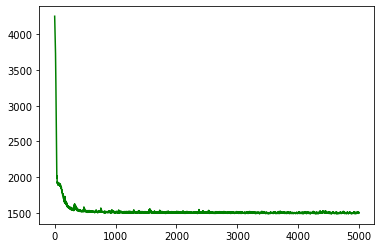

Final train NLL(bits): 1504.460693359375
Val NLL(bits)


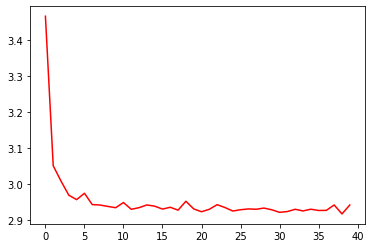

Final valid NLL(bits): 2.941605567932129


In [46]:
realnvp = RealNVP(hidden_dim=400).to(device)
print("Number of parameters: {}".format(sum(p.numel() for p in realnvp.parameters())))
train_realnvp(realnvp, X_train, X_val)

Now evaluate your model: calculate NLL in bits on your validation set.

In [47]:
# Implement NLL calculation on X_val data
val_nll_bits = eval_nll(realnvp, X_val)
print("NLL on validation set in bits: {}".format(val_nll_bits))

NLL on validation set in bits: 2.941605567932129


Feel free to tune your model parameters to improve your NLL score!

Now it's time for some visualizations! Let's calculate flow values of our validation data.

In [48]:
sampled_flow = realnvp(torch.Tensor(X_val).to(device))[0].detach().cpu().numpy()

Now we will visualize our points before and after passing throw the flow, leaving the label color.

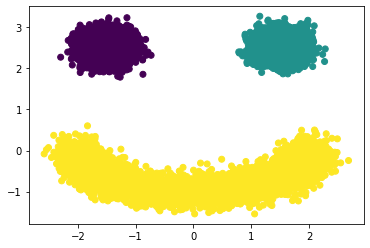

In [49]:
plt.scatter(X_val.T[0], X_val.T[1], c = Y_val)
plt.show()

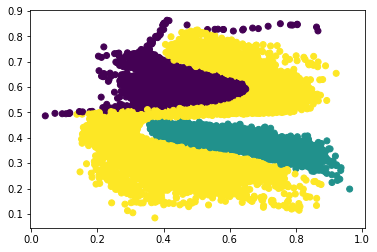

In [50]:
plt.scatter(sampled_flow.T[0], sampled_flow.T[1], c = Y_val)
plt.show()

Finally, let's perform sampling from RealNVP and visualize their histogram to compare with testing data.

In [51]:
def sample_from_realnvp(model):
    x1 = random.random()
    x2 = random.random()
    latent = torch.Tensor([[x1, x2]]).to(device)
    result = realnvp.reverse(latent)[0]
    
    return result.detach().cpu().numpy()

In [52]:
sampled_data = [sample_from_realnvp(realnvp) for _ in range(X_test.shape[0])]
sampled_data = np.array(sampled_data)

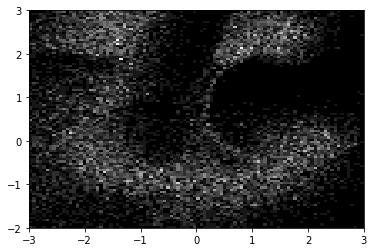

In [53]:
plt.hist2d(sampled_data.T[0], sampled_data.T[1], bins=100, cmap='gray',range=[[-3, 3], [-2, 3]])
plt.show()

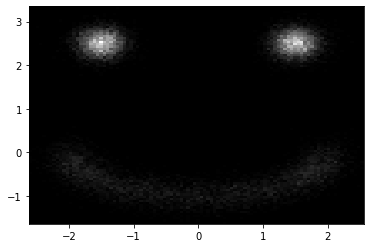

In [54]:
plt.hist2d(X_test.T[0], X_test.T[1], bins=100, cmap='gray')
plt.show()